<a href="https://colab.research.google.com/github/khushipr/Parameter_Optimization_of_SVM/blob/main/Parameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

###Uploading the Dataset from UCI Library

In [2]:
dataset = pd.read_csv('Occupancy_Estimation.csv')
dataset.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


###Pre-Processing of Dataset

In [3]:
dataset.shape

(10129, 19)

In [4]:
dataset.isnull().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

In [5]:
dataset = dataset.drop(['Date','Time'],axis=1)

<AxesSubplot:xlabel='Room_Occupancy_Count', ylabel='count'>

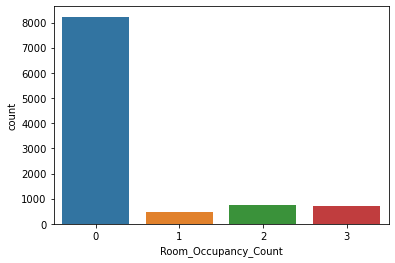

In [6]:
sns.countplot(x = 'Room_Occupancy_Count', data=dataset)

In [7]:
X = dataset.iloc[:,0:-1]
y = dataset['Room_Occupancy_Count']

In [8]:
ss = StandardScaler()
ss.fit_transform(X)

array([[-1.46303347, -1.35777517, -1.16233429, ...,  0.66446859,
        -0.31474885, -0.29402867],
       [-1.46303347, -1.35777517, -1.16233429, ...,  0.558817  ,
        -0.31474885, -0.29402867],
       [-1.29225542, -1.35777517, -1.30276354, ...,  0.4498638 ,
        -0.31474885, -0.29402867],
       ...,
       [-0.92223631, -0.82903247, -0.85807092, ...,  0.00414617,
        -0.31474885, -0.29402867],
       [-0.92223631, -0.82903247, -0.85807092, ...,  0.00414617,
        -0.31474885, -0.29402867],
       [-0.92223631, -0.82903247, -0.85807092, ...,  0.00414617,
        -0.31474885, -0.29402867]])

###Creation of 10 samples with 70-30 ratio of Training and Testing Set

In [9]:
samples = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    samples.append((X_train, X_test, y_train, y_test))

In [10]:
samples

[(      S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  S3_Light  \
  8983    25.25    25.31    24.94    25.44         0         0         0   
  1142    25.69    25.75    25.38    25.94         0         0         0   
  3680    26.25    26.19    26.00    26.38       114        19       180   
  9889    25.06    25.06    24.56    25.25         0         0         1   
  8334    25.94    26.19    25.88    25.94       146       231       170   
  ...       ...      ...      ...      ...       ...       ...       ...   
  9225    25.19    25.25    24.75    25.38         0         0         0   
  4859    25.19    25.19    24.63    25.56         0         0         0   
  3264    25.88    26.81    25.50    26.25       120        26        48   
  9845    25.06    25.06    24.56    25.19         0         0         0   
  2732    25.19    25.13    24.81    25.69        12        14        58   
  
        S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  S5_CO2_Slope  \
  8

### Creation of a Fitness Function

In [11]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
result = pd.DataFrame(columns=['Sample', 'Best Accuracy', 'Best Kernel', 'Best Nu', 'Best Epsilon'])

In [12]:
def fitnessFunction(kernel, C, gamma):
  svm = SVC(kernel=kernel, C=C, gamma=gamma, max_iter=1000)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_test)
  return accuracy_score(y_pred, y_test)

### Calling the Function for Every Sample

In [13]:
for i in range(len(samples)):
  best_accuracy = 0
  best_C = 0
  best_gamma = 0
  for kernel in kernels:
    X_train, X_test, y_train, y_test = samples[i]
    C = np.random.uniform(0, 10)
    gamma = np.random.uniform(0, 10)
    score = fitnessFunction(kernel, C, gamma)
    if score>best_accuracy:
      best_accuracy = round(score, 2)
      best_C = round(C, 2)
      best_gamma = round(gamma, 2)
      best_kernel = kernel
  print('Best Accuracy = ', best_accuracy, 'Best Kernel = ', best_kernel, 'Best Nu = ', best_C, 'Best Epsilon = ', best_gamma)
  result.loc[i] = [i+1, best_accuracy, best_kernel, best_C, best_gamma]

Best Accuracy =  0.88 Best Kernel =  poly Best Nu =  2.64 Best Epsilon =  9.95
Best Accuracy =  0.95 Best Kernel =  linear Best Nu =  7.0 Best Epsilon =  1.38
Best Accuracy =  0.96 Best Kernel =  linear Best Nu =  9.11 Best Epsilon =  9.44
Best Accuracy =  0.94 Best Kernel =  poly Best Nu =  8.19 Best Epsilon =  4.22
Best Accuracy =  0.93 Best Kernel =  linear Best Nu =  1.69 Best Epsilon =  9.72
Best Accuracy =  0.84 Best Kernel =  poly Best Nu =  7.53 Best Epsilon =  1.88
Best Accuracy =  0.91 Best Kernel =  poly Best Nu =  4.38 Best Epsilon =  7.09
Best Accuracy =  0.96 Best Kernel =  poly Best Nu =  4.25 Best Epsilon =  3.44
Best Accuracy =  0.93 Best Kernel =  poly Best Nu =  3.99 Best Epsilon =  4.74
Best Accuracy =  0.95 Best Kernel =  poly Best Nu =  9.14 Best Epsilon =  3.99


###Creation of a Result Table

In [14]:
result

,Sample,Best Accuracy,Best Kernel,Best Nu,Best Epsilon
0,1,0.88,poly,2.64,9.95
1,2,0.95,linear,7.00,1.38
2,3,0.96,linear,9.11,9.44
3,4,0.94,poly,8.19,4.22
4,5,0.93,linear,1.69,9.72
5,6,0.84,poly,7.53,1.88
6,7,0.91,poly,4.38,7.09
7,8,0.96,poly,4.25,3.44
8,9,0.93,poly,3.99,4.74
9,10,0.95,poly,9.14,3.99


### Plotting of the Convergence Graph/Linear Curve

In [15]:
X_train, X_test, y_train, y_test = samples[result['Best Accuracy'].idxmax()]

In [16]:
train_sizes, train_scores, test_scores = learning_curve(SVC(kernel=result['Best Kernel'].iloc[result['Best Accuracy'].idxmax()], 
                                                        C=result['Best Nu'].iloc[result['Best Accuracy'].idxmax()],
                                                        gamma=result['Best Epsilon'].iloc[result['Best Accuracy'].idxmax()],
                                                        max_iter = 1000), X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1,
                                                        train_sizes = np.linspace(0.01, 1.0, 50))

In [17]:
train_sizes

array([  63,  192,  321,  450,  579,  708,  837,  966, 1095, 1224, 1353,
       1481, 1610, 1739, 1868, 1997, 2126, 2255, 2384, 2513, 2642, 2771,
       2900, 3029, 3157, 3286, 3415, 3544, 3673, 3802, 3931, 4060, 4189,
       4318, 4447, 4576, 4705, 4833, 4962, 5091, 5220, 5349, 5478, 5607,
       5736, 5865, 5994, 6123, 6252, 6381])

In [18]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

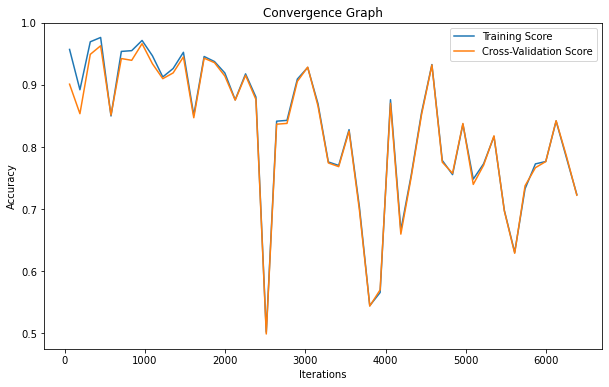

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Convergence Graph')
plt.legend(loc="best")
plt.show()